# Importing libraries

In [62]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [63]:
# Configure API key 

quandl.ApiConfig.api_key = 'VoJcTZhinMdc9BjVQTih'

# # Importing the"Gross Domestic Product (GDP)" variable data of Federal Reserve Economic Data from Quandl.

In [64]:
data = quandl.get('FRED/GDP')

In [101]:
data.head(5)

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [102]:
data.tail(5)

,Value
Date,
2020-10-01,21477.597
2021-01-01,22038.226
2021-04-01,22740.959
2021-07-01,23202.344
2021-10-01,23992.355


In [66]:
data.shape

(300, 1)

In [67]:
data.columns

Index(['Value'], dtype='object')

In [68]:
type(data)

pandas.core.frame.DataFrame

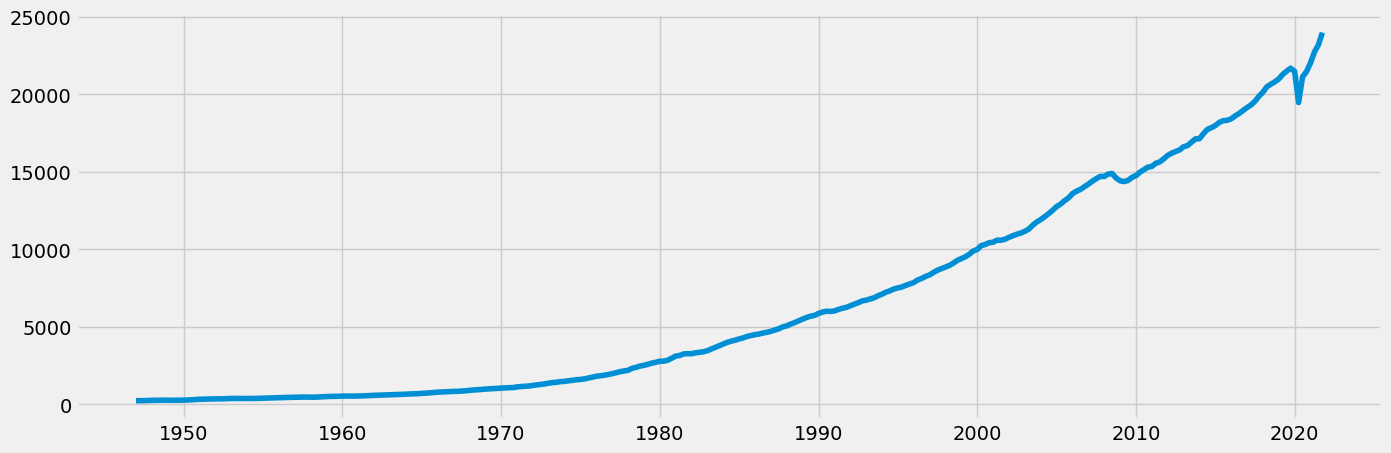

In [69]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [78]:
# Reset index so that i can use the "Date" column as a filter

data_2 = data.reset_index()

In [79]:
data_2.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


# Subsetting

## For this example, we only need values after January 1980 and before June 2021. The former due to the fact that economic conditions in the present are different than in the 50s to 80s, so we wouldn’t want that data incorrectly influencing our calculations, and the latter due to the fact that anything after June 2021 is a prediction.

In [103]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2021-06-01')]

In [104]:
data_sub.shape

(166, 2)

In [105]:
data_sub.head()

,Date,Value
132,1980-01-01,2789.842
133,1980-04-01,2797.352
134,1980-07-01,2856.483
135,1980-10-01,2985.557
136,1981-01-01,3124.206


In [106]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,2789.842
1980-04-01,2797.352
1980-07-01,2856.483
1980-10-01,2985.557
1981-01-01,3124.206


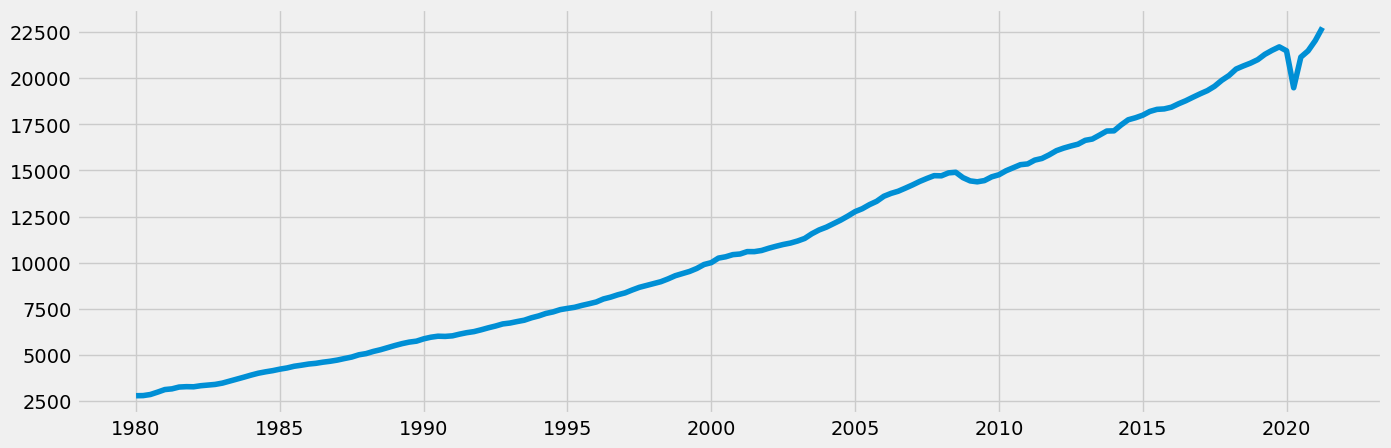

In [107]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## The overall trend is increasing from 1980, slight decline after 2008 and 2019. then improving as normal.

In [108]:
# Check for missing values.

data_sub.isnull().sum() 

Value    0
dtype: int64

In [109]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

# 3. Time-series analysis: decomposition

In [110]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [111]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

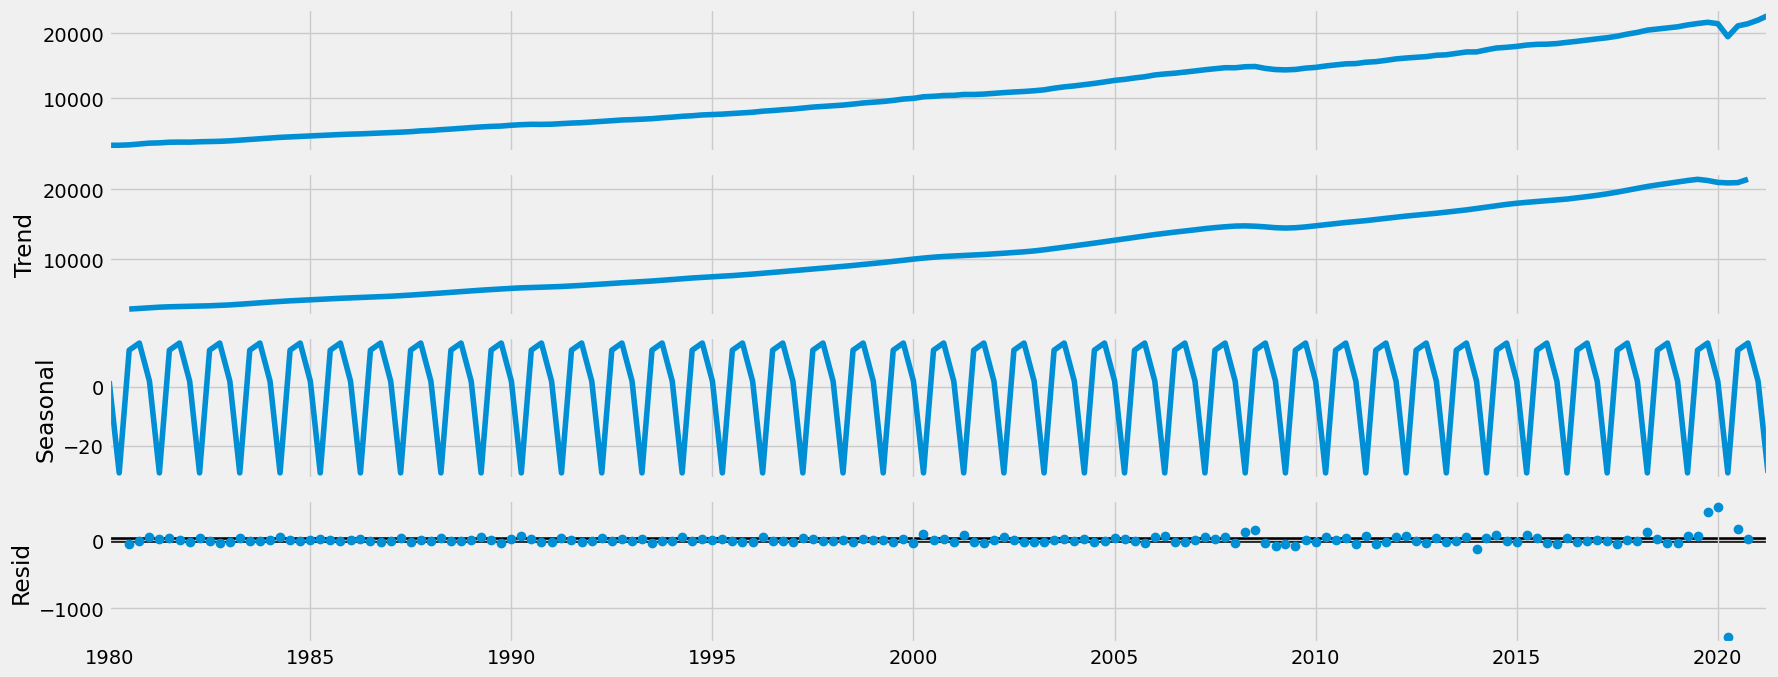

In [112]:
# Plot the separate components

decomposition.plot()
plt.show()

In [113]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why i need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.558605
p-value                          0.999066
Number of Lags Used              8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


### If the test statistic is more negative than the critical value at a certain significance level, we can reject the null hypothesis and conclude that the data is stationary.
### If the p-value is less than a chosen significance level (commonly 0.05), we can also reject the null hypothesis and conclude that the data is stationary.
## In this case, since the p-value (0.999066) is greater than the commonly chosen significance level of 0.05 and the test statistic (2.558605) is not more negative than the critical values, we fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that this GDP data is stationary. GDP data may exhibit trends or seasonality.

## Verify using Multiplicative

In [114]:
# Decompose the time series using an multiplicativ model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='multiplicative')

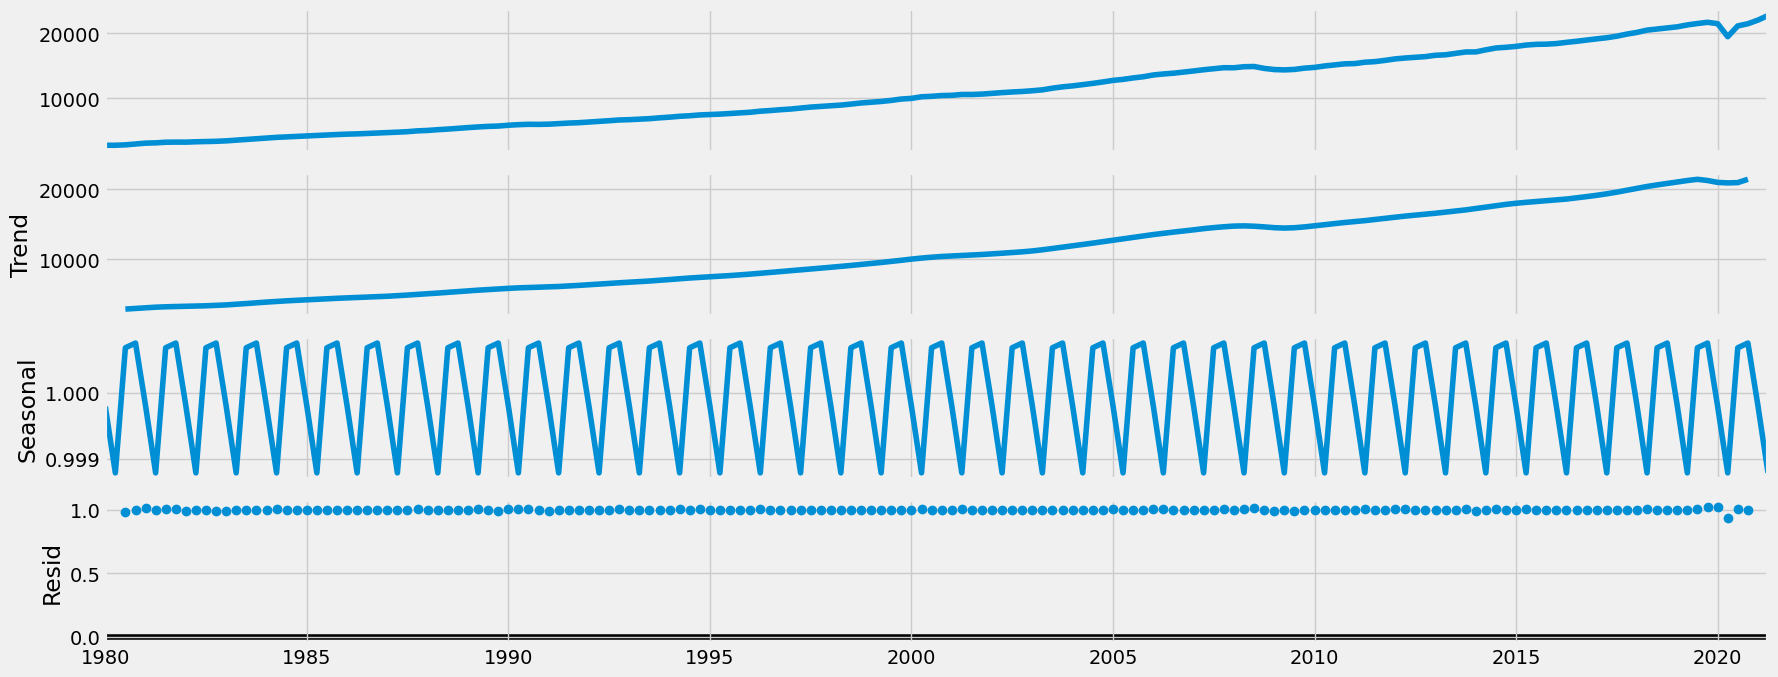

In [115]:
# Plot the separate components

decomposition.plot()
plt.show()

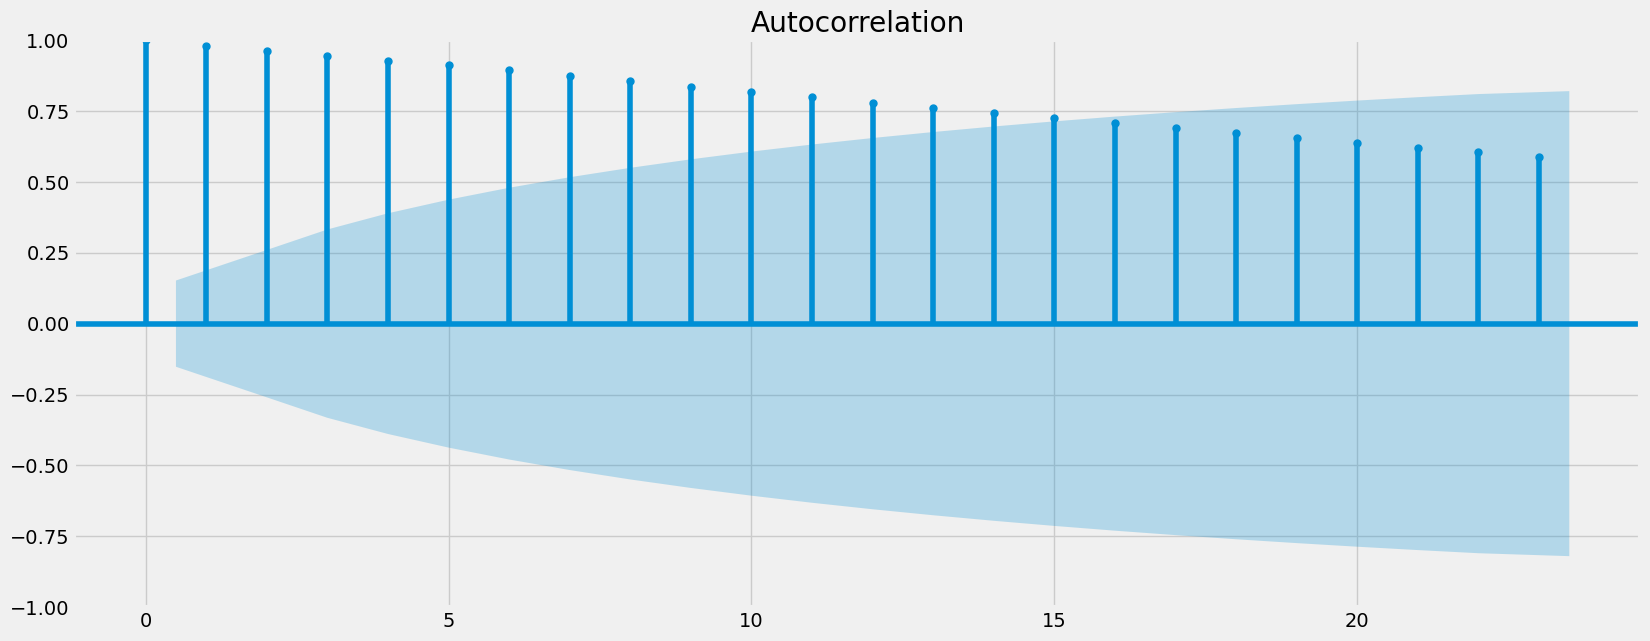

In [116]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here,i import the autocorrelation & partial correlation plots

plot_acf(data_sub)
plt.show()

## there is a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test conducted just before.

# 5. Stationarizing the GDP Federal Reserve Economic Data 

In [117]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [118]:
data_diff.dropna(inplace = True) # Here,i remove the missing values that came about as a result of the differencing. 


In [119]:
data_diff.head()

,Value
datetime,
1980-04-01,7.510
1980-07-01,59.131
1980-10-01,129.074
1981-01-01,138.649
1981-04-01,38.326


In [120]:
data_diff.columns

Index(['Value'], dtype='object')

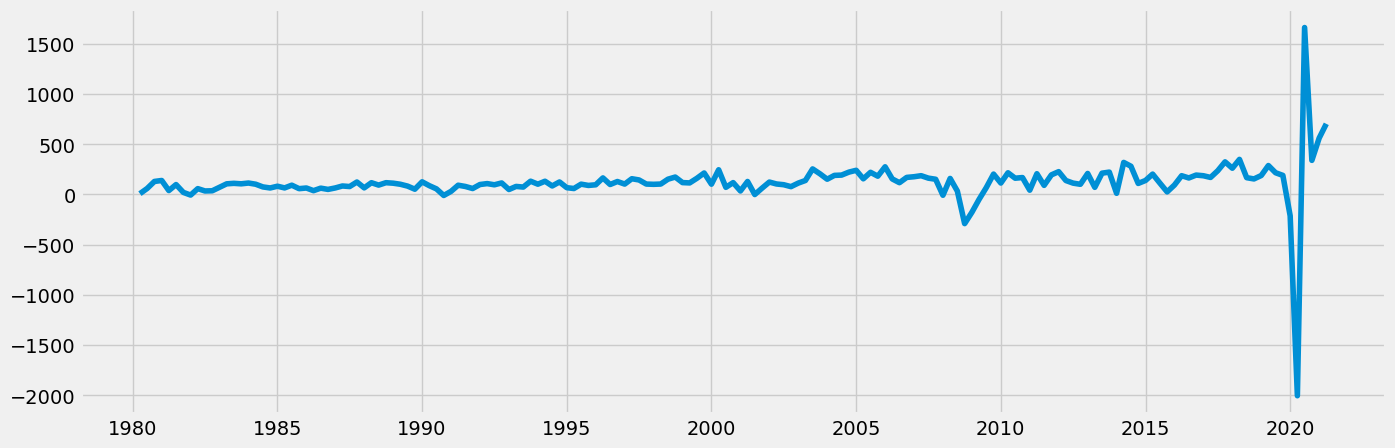

In [121]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [122]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.464400
p-value                          0.000228
Number of Lags Used              7.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


## After Stationarizing
###  test statistic (-4.464400) is more negative than the critical values at all three significance levels, indicating that it falls in the rejection region. This suggests that there is strong evidence to reject the null hypothesis of non-stationarity.

### also the p-value (0.000228) is significantly lower than the commonly chosen significance level of 0.05. This further supports the rejection of the null hypothesis.

## In summary, based on the test statistic and the p-value, we have strong evidence to conclude that our GDP data is stationary. This indicates that the trends or seasonality present in the data have been removed or minimized, making it suitable for time series analysis or modeling.

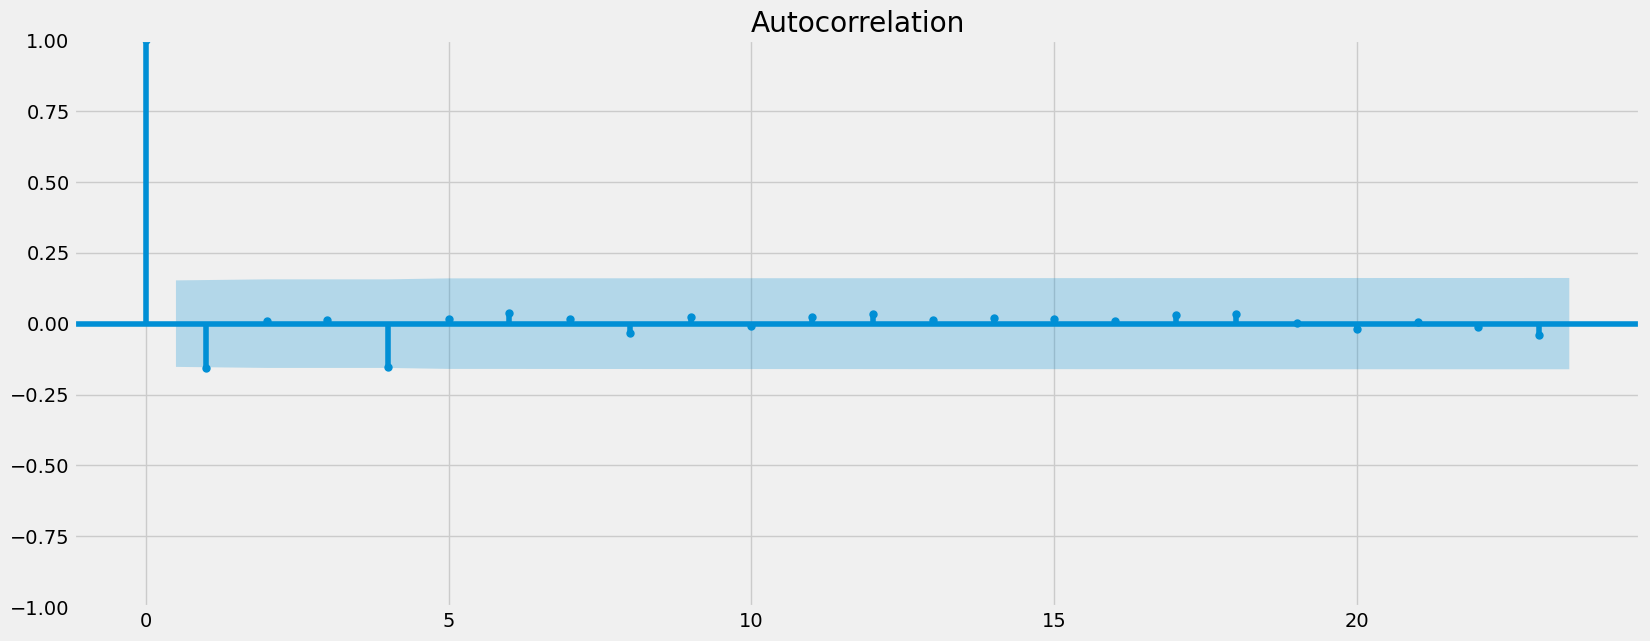

In [123]:
# Check autocorrelations
plot_acf(data_diff)
plt.show()

## Autocorrelation plot has improved a lot, only very few autocorrelated.